# Text Classification Example using LSTM and Keras
In this Example we will see how we can do the binary classification using LSTM model with Keras framework.

**We have used the SMS Spam Data set in our example, which is available at the following location**
* SMS Spam Collection Data Set (https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)

In this example our model will learn to classify a SMS message in spam or ham. 


In [1]:
# Download the SMS Spam data file if doesn't exist already
import os
import requests # This library is used to make requests to internet
import zipfile

data_file = "data/SMSSpamCollection"

# Download and unzip the data file in data directory in case it doesn't exists already
if not os.path.exists(data_file):
    data_file_dir = os.path.dirname(data_file)
    if not os.path.exists(data_file_dir): os.makedirs(data_file_dir)

    # Storing url of dataset
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(url, allow_redirects=True)
    zip_file_download = data_file_dir + '/smsspamcollection.zip'

    # Writing the content of above request to 'smsspamcollection.zip' file
    open(zip_file_download, 'wb').write(r.content)
    
    # Extract the zip file
    with zipfile.ZipFile(zip_file_download,"r") as zip_ref:
        zip_ref.extractall(data_file_dir)


In [2]:
from util import load_data_and_labels_from_csv_file, build_vocab, pad_sentences, text_to_sequence, save_vocab_json, generate_word_level_features, customCallBack

print("Loading data (labels and sentences) from the SMSSpamCollection file...")
labels, sentences = load_data_and_labels_from_csv_file(data_file)

print(labels[:5])
print(sentences[:5])

Loading data (labels and sentences) from the SMSSpamCollection file...
[0 0 1 0 0]
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'
 'Ok lar... Joking wif u oni...'
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
 'U dun say so early hor... U c already then say...'
 "Nah I don't think he goes to usf, he lives around here though"]


In [3]:
import numpy as np

# Param defining max features consider in a sentence
params = {'max_words_features': 50} 

# Generate word features for every message
lines_words_level_features = generate_word_level_features(sentences, params['max_words_features'])
# Redefine the max_words_features in case existing data contains the 
# max word featues less then define one for all the messages
params['max_words_features'] = max([len(lines) for lines in lines_words_level_features])

# Convert to numpy array
lines_words_level_features = np.array(lines_words_level_features)
lines_words_level_features[:5]

array([list(['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']),
       list(['ok', 'lar', 'joking', 'wif', 'u', 'oni']),
       list(['free', 'entry', 'in', '<n/>', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '<n/>', 'text', 'fa', 'to', '<n/>', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'cs', 'apply', '0845281075over18s']),
       list(['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']),
       list(['nah', 'i', 'dont', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though'])],
      dtype=object)

In [4]:
# Build vocabulary, assigning a unique index value to every word
# Special tokens <UNK/> for unknown words, <PAD/> for padding a sentence, 
# Other special tokens are <n\> if a word contains all numeric charactrs, 
# and <sd\> is all special characters with or without digits
print("Build the vocabulary, assigning a unique index value to every word")
vocabulary = build_vocab(lines_words_level_features, max_vocab_size=10000)

import itertools 
# Print 10 Vocabulary items
for i, val in enumerate(itertools.islice(vocabulary, 10)):
    print(i, val, vocabulary[val])

Build the vocabulary, assigning a unique index value to every word
0 <UNK/> [0, inf]
1 <PAD/> [1, inf]
2 <n/> [2, 2585]
3 i [3, 2260]
4 to [4, 2211]
5 you [5, 2108]
6 a [6, 1423]
7 the [7, 1305]
8 u [8, 1156]
9 and [9, 957]


In [5]:
# Pad sentence
print("Padding sentences...")
x_text = pad_sentences(lines_words_level_features, max_sequence_length=params['max_words_features'])

# Get max sequence length, should be equal to max_words_features
seq_len = len(x_text[0]) 
print("The sequence length is: ", seq_len)
x_text[0][:30]

Padding sentences...
The sequence length is:  50


['go',
 'until',
 'jurong',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'there',
 'got',
 'amore',
 'wat',
 '<PAD/>',
 '<PAD/>',
 '<PAD/>',
 '<PAD/>',
 '<PAD/>',
 '<PAD/>',
 '<PAD/>',
 '<PAD/>',
 '<PAD/>',
 '<PAD/>']

In [6]:
# Represent sentence with word index, using word index to represent a sentence
x = text_to_sequence(x_text, vocabulary)
x[0]

array([  48,  441,    0,  776,  701,  670,   66,   10, 1217,   95,  128,
        370, 1218,  149, 2765, 1219,   72,   59,    0,  141,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1])

In [7]:
# Shuffle data
#np.random.seed(1) #same shuffling each time
shuffle_indices = np.random.permutation(np.arange(len(labels)))
x = x[shuffle_indices]
labels = labels[shuffle_indices]
print(x[:3])
print(labels[:3])

[[  50  181    0  181    0  132   66 1194  227  215   35 1330 2498   18
     2  480  197    2   85   91  437   18    2    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1]
 [  22   66    3  958   82    3   65  168  842   22    3   37   63 3222
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1]
 [  26  256    0    4  359 1990   24   10  416    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1]]
[1 0 0]


In [8]:
import keras
from keras.layers import Embedding, Dropout, LSTM, Dense
from keras.models import Sequential

"""
## Build LSTM model
"""
vocab_size_or_total_features = len(vocabulary) 

embed_dim = 100 
embedding_dropout_factor = 0.2 
recurrent_dropout_factor = 0.2 
LSTM_dropout_factor = 0.2 
layer_dropout_factor = 0.2 
LSTM_layer_sizes = [512]

model = Sequential()
model.add(Embedding(vocab_size_or_total_features, embed_dim, input_length=seq_len))
model.add(Dropout(embedding_dropout_factor))
"""
for size in LSTM_layer_sizes[:-1]:
    model.add(LSTM(units=size, return_sequences=True,
                       recurrent_dropout=recurrent_dropout_factor,
                       dropout=LSTM_dropout_factor))
    model.add(Dropout(layer_dropout_factor))
"""
model.add(LSTM(units=LSTM_layer_sizes[-1], recurrent_dropout=recurrent_dropout_factor, dropout=LSTM_dropout_factor))
model.add(Dropout(layer_dropout_factor))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           404200    
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1255424   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 1,660,137
Trainable params: 1,660,137
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
from keras.callbacks import ModelCheckpoint 
from keras.optimizers import Adam

checkpoint_path = "model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create check_point dir if not already exists
if not os.path.exists(checkpoint_dir): os.makedirs(checkpoint_dir)

# Save Vocabulary in checkpoint directory
vocab_file = checkpoint_dir + "/vocab.json"
save_vocab_json(vocab_file, vocabulary, params)

# Define the checkpoint
checkpoint = ModelCheckpoint(filepath=checkpoint_path,  monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto') # Create callback to save the weights
# Trnsorboard settings
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=checkpoint_dir, histogram_freq=0)
# Optimizer settings
adam = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-8)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# Paameters
epochs = 50
batch_size = 32
verbose = 1
validation_split = 0.2
max_patience = 20

print("Traning Model...")
callbacks=[customCallBack(model, checkpoint_path, max_patience=max_patience), tensorboard_callback]
history=model.fit(x, labels, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_split=validation_split, callbacks=callbacks)


Traning Model...
Epoch 1/50
  1/140 [..............................] - ETA: 0s - loss: 0.7061 - accuracy: 0.0938WARNING:tensorflow:From /usr/local/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
140/140 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.7733Saving as validation accuracy increased from  2.2250738585072014e-308  to  0.870851993560791
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/cp.ckpt/assets
140/140 [==============================] - 62s 446ms/step - loss: 0.6185 - accuracy: 0.7733 - val_loss: 0.3291 - val_accuracy: 0.8709
Epoch 2/5

Epoch 22/50
140/140 [==============================] - 80s 569ms/step - loss: 0.0425 - accuracy: 0.9863 - val_loss: 0.0625 - val_accuracy: 0.9803
Epoch 23/50
140/140 [==============================] - 82s 588ms/step - loss: 0.0408 - accuracy: 0.9881 - val_loss: 0.0615 - val_accuracy: 0.9803
Epoch 24/50
140/140 [==============================] - 80s 571ms/step - loss: 0.0391 - accuracy: 0.9879 - val_loss: 0.0603 - val_accuracy: 0.9794
Epoch 25/50
140/140 [==============================] - 87s 624ms/step - loss: 0.0369 - accuracy: 0.9886 - val_loss: 0.0599 - val_accuracy: 0.9821
Epoch 26/50
140/140 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9872Saving as validation accuracy increased from  0.9829596281051636  to  0.9838564991950989
INFO:tensorflow:Assets written to: model/cp.ckpt/assets
140/140 [==============================] - 84s 599ms/step - loss: 0.0400 - accuracy: 0.9872 - val_loss: 0.0601 - val_accuracy: 0.9839
Epoch 27/50
140/140 [====================

Epoch 49/50
140/140 [==============================] - 64s 454ms/step - loss: 0.0198 - accuracy: 0.9939 - val_loss: 0.0540 - val_accuracy: 0.9874
Epoch 50/50
140/140 [==============================] - 66s 473ms/step - loss: 0.0173 - accuracy: 0.9946 - val_loss: 0.0629 - val_accuracy: 0.9848


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


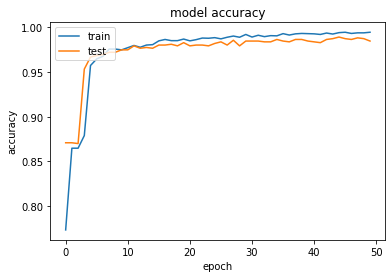

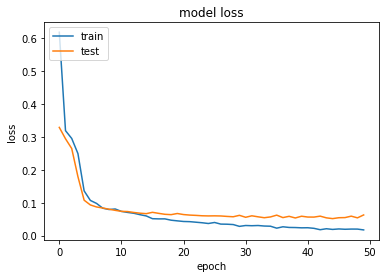

In [10]:
# Plot the accuracy, Val_accuracy and loss
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# Prediction of given text

x_text = ["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 
          "I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."]

lines_words_level_features = generate_word_level_features(x_text, params['max_words_features'])
lines_words_level_features = np.array(lines_words_level_features)

seq_len = params['max_words_features'] 

x = pad_sentences(lines_words_level_features, max_sequence_length=seq_len, is_max_sequence_length_modifiable=False)
x = text_to_sequence(x, vocabulary)

print("Generate predictions")
predictions = model.predict(x)
count = 0 
for text in x_text:
    print("Text is: \t", text)
    if (predictions[count] > 0.5):
        print("predicted spam with spam prob ", predictions[count])
    else:
        print("predicted ham with spam prob ", predictions[count])
    count += 1 


Generate predictions
Text is: 	 Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
predicted spam with spam prob  [0.9999218]
Text is: 	 I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
predicted ham with spam prob  [0.00041172]
